In [1]:
import numpy as np
import requests
import re

from bs4 import BeautifulSoup

from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag
from nltk import PorterStemmer
from nltk.corpus import stopwords
import re

In [2]:
stop_words = stopwords.words('english')
def get_movie_soup(link):
    response = requests.get(link)
    movie_soup = BeautifulSoup(response.content, 'html.parser')
    return movie_soup



#### Find character names
They will be bold and will be followed by their text

In [3]:
from collections import defaultdict, OrderedDict
string_list = ["FINN", "EXT. NIIMA OUTPOST - DAY", "I/E MARK'S FORD - DAY",
              "CUT TO:", "(to chewie)"]

def is_scene(string, tags=['INT.', 'EXT.', 'I/E', '-']):
    int_or_ext = [i in string.upper() for i in tags]
    return sum(int_or_ext) != 0

BEG_PARENS_REGEX = re.compile(r'\(')
def is_addressant(string):
    if BEG_PARENS_REGEX.match(string):
        return True
    else:
        return False


# for i in zip(string_list, map(is_scene, string_list)):
#     print "is scene?: ", i
# for i in zip(string_list, map(is_addressant, string_list)):
#     print "is addressant?: ", i

In [4]:
a = 'hello      high     how are you.  There.'
rey = "REY (CONT'D)"
han = "HAN (Continued)"
ext = "EXT. SOMETHING DARKSIDE"

WHT_SPC_REGEX = re.compile(r'\s{2,}')
def remove_long_white_space(string):
    new_string = WHT_SPC_REGEX.sub(' ', string)
    return new_string

PARENS_REGEX = re.compile(r'(\w{2,})+\s(.*)')
def remove_parens(string):
    if "(" in string:        
        new_string = PARENS_REGEX.sub(r'\1', string)
        return new_string
    else:
        return string


remove_parens(ext)

'EXT. SOMETHING DARKSIDE'

## Put your soup in here!

In [5]:
# bad_country = get_movie_soup('http://www.imsdb.com/scripts/Bad-Country.html')
# star_wars = get_movie_soup('http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html')
# few_good_men = get_movie_soup('http://www.imsdb.com/scripts/A-Few-Good-Men.html')

In [6]:
def get_movie_script(link):
    movie_soup = get_movie_soup(link)
    movie_text = movie_soup.findAll('pre')[0]
    return str(movie_text)
# script = few_good_men.findAll('pre')[0]


In [7]:
def clean_text(text):
    bold_splits = text.split('<b>')

    character_docs = defaultdict(list)
    scene_docs = defaultdict(list)

    character_sents = []
    character_track = []

    current_scene = None
    prior_character = None
    missed_things = 0
    porter_stemmer = PorterStemmer()
    for slug in bold_splits:
        phrase = slug.strip().split('</b>')
        bold = phrase[0].strip()
        bold = remove_parens(bold)

        if is_scene(bold):
            current_scene = bold

        try:
            sentences = phrase[1].strip()        
            if not is_scene(bold):
                sentences_list = sent_tokenize(sentences, language="english")
                for sent in sentences_list:
                    sent_cleaned = sent.replace("\r\n", "")
                    sent_cleaned = remove_long_white_space(sent_cleaned)
                    sent_cleaned = sent_cleaned.lower()
                    current_character = bold
                    if is_addressant(bold):
                        current_character = prior_character

                    if sent_cleaned != None and current_scene != None\
                    and current_character != None:
                        sent_cleaned = sent_cleaned.split(" ")
                        sent_cleaned = " ".join(porter_stemmer.stem_word(word) for word in sent_cleaned)
                        character_docs[current_character].append((
                        " ".join([sent_cleaned, current_scene])))
    #                     character_sents.append((sent_cleaned, current_scene))
    #                     character_track.append(current_character)

                    prior_character = bold


        except IndexError:
            pass
            missed_things += 1
    return character_docs



def order_character_dict(dictionary):
    characters = dictionary.keys()
    for name in characters:
        for name_scan in characters:
            if name in name_scan and name != name_scan:
                dictionary[name] += dictionary[name_scan]
                dictionary[name_scan] = []

    ordered = OrderedDict(sorted(dictionary.items(), 
                                 key=lambda t: len(t[1]), 
                                 reverse=True))
    return ordered

# def get_ch_docs

def gen_char_tags(characters_to_analyze, character_docs):

    sentence_list = []
    char_tags = []
    for character in characters_to_analyze:
        for line in character_docs[character]:
            sentence_list.append(line)
            char_tags.append(character)
    return char_tags, sentence_list

# Vectorize and SVD Per Character

Need to reduce for set of characters then cluster (then grab cosine similarity of the means of c

In [8]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds as SVDS

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [9]:
script = get_movie_script('http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html')
character_docs = order_character_dict(
    clean_text(script))
characters_to_analyze = character_docs.keys()[0:4]
characters_to_analyze = ['LEIA', 'MAZ', 'REY']
char_tags, sentence_list = gen_char_tags(characters_to_analyze, character_docs)


(0, 1)

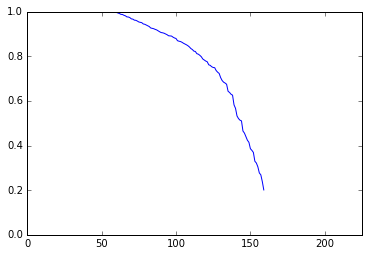

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
x = vectorizer.fit_transform(sentence_list).T
T,sigma,D_trans = SVDS(x, k=160)
D = D_trans.T
plt.plot(1/sigma)
plt.xlim(0, 225)
plt.ylim(0, 1)

In [11]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AffinityPropagation

from sklearn.metrics.pairwise import distance_metrics 

Look at this it appears I could use 

#### Correlation Map

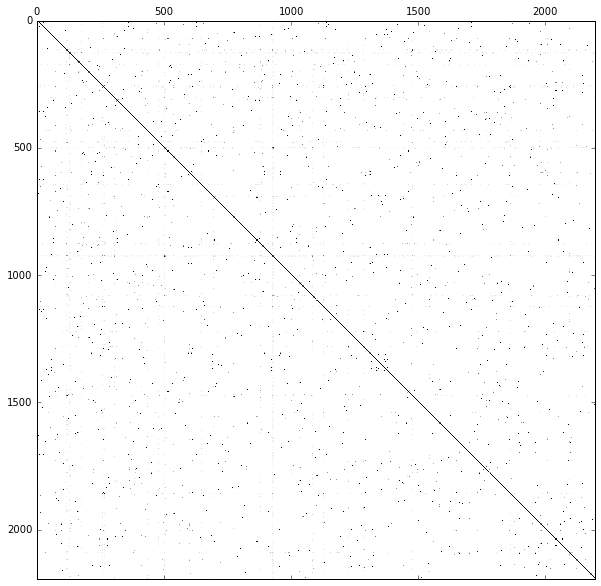

In [12]:
pair_dist = pdist(x.toarray(), 'cosine')
v = squareform(pair_dist)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.matshow(v, cmap=plt.cm.gray)

#### TSNE (plotting high dimension into 2D)

In [13]:
from sklearn.metrics.pairwise import pairwise_distances

In [14]:
ryans_cosine = lambda x, y: pairwise_distances(x, Y=y, metric='cosine') + 1

# stop

In [ ]:
digits_proj = TSNE(random_state=0, n_components=2, metric=ryans_cosine).fit_transform(D)

In [ ]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
    plt.xlim(-.1, .1)
    plt.ylim(-.1, .1)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in set(colors):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
#         print "x is", x
#         print "colors is: ", colors
        txt = ax.text(xtext, ytext, characters_to_analyze[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
#     for char in 
    return f, ax, sc, txts

char_convert_num = dict(enumerate(characters_to_analyze))
char_convert_num = {v: k for k, v in char_convert_num.items()}
y = np.array(map(lambda x: char_convert_num[x], char_tags))
scatter(digits_proj, y);

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(linkage='', affinity='cosine')

In [ ]:
agg_cluster.fit(x.toarray())